In [1]:
import matplotlib.pyplot as plt
import pde
import pandas as pd
import numpy as np
import torch
torch.manual_seed(42)

import pandas as pd
from torch.nn import functional as F


from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

ImportError: /usr/lib/libtorch_cpu.so: undefined symbol: cblas_gemm_f16f16f32

In [4]:
def solveEquationPYPDE(variable, eq, ic="2/cosh(x)**2", xrange=None, yrange=None, points=100, trange=pi/2):
    #initialize xrangenp.linspace(0, 10, 100).reshape(-1, 1)
    if xrange is None:
        xrange = [-5, 5]

    # define an interval
    int = trange/100
    
    #eq is passed in as a string with x as the dependent variable
    eq = pde.PDE({variable: eq})
    
    if yrange is not None:
        grid = pde.grids.CartesianGrid([xrange, yrange], [points], periodic=[True, True])
    else:
        grid = pde.grids.CartesianGrid([xrange], [points],  periodic=True)
    
    field = pde.ScalarField.from_expression(grid, ic)
    bc = ["periodic", {'derivative': 'periodic'}]
    #field /= np.sqrt(field.to_scalar('norm_squared').integral.real)

    storage = pde.MemoryStorage()
    trackers = ['progress', storage.tracker(interval=int)]
    
    solver = pde.ExplicitSolver(eq, backend='numba' ,scheme='runge-kutta', adaptive=True, tolerance=1e-9)
    controller = pde.Controller(solver, t_range=trange, tracker=trackers)
    solution = controller.run(field, dt=1e-5)
    
    return field, storage

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.5707963267948966/1.5707963267948966 [00:05<00:00,  3.32s/it]


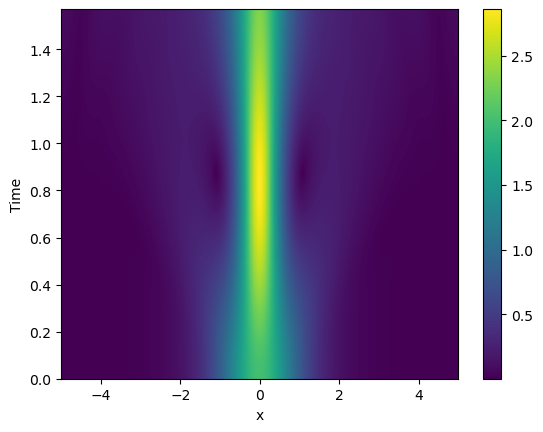

In [5]:
s1, st1 = solveEquationPYPDE('phi', f"0.5 * I * laplace(phi) + I * (phi*conjugate(phi)) * phi")
pde.plot_kymograph(st1)

In [6]:
numerical = np.array(st1.data)[:100,:]
real = numerical.real
imag = numerical.imag
numabs = np.sqrt(real**2 + imag**2)

In [7]:
#p1 = plt.pcolormesh(x_grid.numpy(), t_grid.numpy(), numabs)
#plt.colorbar(p1)
#plt.show()

NameError: name 'x_grid' is not defined

In [8]:
def preds_and_errors_nse(model, err=1):
    pred = model.net(xt_pairs)
    absval = torch.sqrt(pred[:,0:1]**2 + pred[:,1:2]**2).reshape((100,100)).detach().cpu()
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, layout='constrained')
    fig.set_figwidth(12)
    #fig.suptitle('Horizontally stacked subplots')
    ax1.set_title("Predicted")
    ax1.set_xlabel("x")
    ax1.set_ylabel("t")
    p1 = ax1.pcolormesh(x_grid.numpy(), t_grid.numpy(), absval.numpy())
    plt.colorbar(p1, ax=ax1)
    ax2.set_title("Error")
    ax2.set_xlabel("x")
    p2 = ax2.pcolormesh(x_grid.numpy(), t_grid.numpy(),  np.abs(absval.numpy()-numabs)/err)
    plt.colorbar(p2, ax=ax2)

In [9]:
x = s1.get_line_data()['data_x'].reshape(-1,1) # X x 1
t = np.array(st1.times).reshape(-1,1) # T x 1
x_grid, t_grid = np.meshgrid(x, t)


phi = np.array(st1.data)
u = np.real(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)   #.flatten()[:,None]
v = np.imag(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)  #.flatten()[:,None]
#plt.pcolormesh(x_grid, t_grid, np.sqrt(u**2 + v**2))

##Generate the two indices
idx1 = np.random.choice(x_grid.shape[0], 50, replace=False)
idx1 = np.sort(idx1)
idx2 = np.random.choice(x_grid.shape[1], 55, replace=False)
idx2 = np.sort(idx2)

def gen_train(grid):
    grid_new = grid[idx1]
    grid_new = grid_new[:,idx2]
    return grid_new
    
x_train, t_train, u_train, v_train = gen_train(x_grid), gen_train(t_grid), gen_train(u), gen_train(v)

In [10]:
## reshape to feed into model
x_train = x_train.flatten()[:,None]
t_train = t_train.flatten()[:,None]

u_train = u_train.flatten()[:,None]
v_train = v_train.flatten()[:,None]

In [206]:
## boilerplate stuff for GPU...
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

## create gridmesh for plotting
x_axis = torch.linspace(-5, 5, 100, dtype=torch.float64) #,dtype=torch.float16)
t_axis = torch.linspace(0, pi/2, 100, dtype=torch.float64) #, dtype=torch.float16)

x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing='xy')
xt_pairs = torch.stack((x_grid, t_grid), dim=2)
xt_pairs = xt_pairs.reshape(xt_pairs.shape[0] * xt_pairs.shape[1],2).to(device)

class PINN():
    def __init__(self, x, t, u, v, dDim=256, nHid=4):
        self.x = torch.tensor(x, dtype=torch.float64, requires_grad=True, device=device) #, dtype=torch.float16,
        self.t = torch.tensor(t, dtype=torch.float64, requires_grad=True, device=device) #, dtype=torch.float16,
        
        self.u = torch.tensor(u, dtype=torch.float64, device=device)
        self.v = torch.tensor(v, dtype=torch.float64, device=device)
        
        self.null = torch.zeros((self.x.shape[0],1), dtype=torch.float64, device=device) #, dtype=torch.float16,
        self.dDim = dDim
        self.nHid = nHid
        self.net_init()
        self.optim1 = torch.optim.LBFGS(self.net.parameters(),
                                       lr=15,
                                       max_iter=1000,
                                       max_eval=1000,
                                       history_size=200,
                                       tolerance_grad=1e-32,
                                       tolerance_change=0.5 * np.finfo(float).eps,
                                       line_search_fn='strong_wolfe'
                                      )

        self.optim2 = torch.optim.Adam(self.net.parameters(), lr=1e-4)
        self.loss = []
        self.mse = torch.nn.MSELoss()
        self.ls = 0
        self.step = 0
    
    def net_init(self, act=torch.nn.Tanh):
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, self.dDim).double(), act(),
            torch.nn.Sequential(*[
                torch.nn.Sequential(*[
                    torch.nn.Linear(self.dDim, self.dDim).double(), act()
            ]) for _ in range(self.nHid)]),
            torch.nn.Linear(self.dDim, 2).double()
        )
        self.net.to(device)

        # for module in self.net.modules():
        #     if isinstance(module, act):
        #         module = torch.cuda.amp.autocast()(module)
    
    def func(self, x, t):
        #with torch.cuda.amp.autocast():
        preds = self.net(torch.hstack((x, t)))
        u, v = preds[:,0:1], preds[:,1:2]
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

        v_t = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True)[0]

        ## define the two parts of the function being approximated
        f_u = u_t + 0.5 * v_xx + (torch.square(u) + torch.square(v))*v 
        f_v = v_t - 0.5 * u_xx - (torch.square(u) + torch.square(v))*u

        return u, v, f_u, f_v
        
    def closure(self):
        self.optim2.zero_grad(set_to_none=True)
        self.optim1.zero_grad(set_to_none=True)

        #with torch.cuda.amp.autocast(dtype=torch.float16):
        u_pred, v_pred, f_u_pred, f_v_pred = self.func(self.x, self.t)
    
        u_loss = self.mse(u_pred, self.u)
        v_loss = self.mse(v_pred, self.v)
        f_u_loss = self.mse(f_u_pred, self.null)
        f_v_loss = self.mse(f_v_pred, self.null)
        
        self.ls = u_loss + v_loss + f_u_loss + f_v_loss
        self.ls.backward()
        
        if not self.step % 100:
            print(f"Step: {self.step}, Loss: {self.ls}")
        
        if self.step in [0,10000,25000]:
            preds_and_errors_nse(self)
        if self.step == 50000:
            preds_and_errors_nse(self)
        self.loss.append(self.ls.item())
        #if self.step < 1100:
        #    self.loss.append(self.ls.item())
        #else:
        #    self.loss.append(self.ls.item()/10)
        self.step += 1
        return self.ls

    def train(self):
        self.net.train()
        for i in range(500):
            self.optim2.step(self.closure)
        print(f"Switching to LBFGS at {self.step}!!")
        self.optim1.step(self.closure)

In [72]:
nse = PINN(x_train, t_train, u_train, v_train, dDim=128, nHid=8)

Step: 0, Loss: 0.5477099418640137


C:\Users\Professional\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\__init__.py:251: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [2750, 1], strides() = [1, 0]
param.sizes() = [2750, 1], strides() = [1, 0] (Triggered internally at ..\torch/csrc/autograd/functions/accumulate_grad.h:219.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step: 100, Loss: 0.5277499556541443
Step: 200, Loss: 0.511425793170929
Step: 300, Loss: 0.4987572133541107
Step: 400, Loss: 0.4904673397541046
Step: 500, Loss: 0.4814719259738922
Step: 600, Loss: 0.4750913977622986
Step: 700, Loss: 0.47161269187927246
Step: 800, Loss: 0.4687774181365967
Step: 900, Loss: 0.46568816900253296
Step: 1000, Loss: 0.46188101172447205
Step: 1100, Loss: 0.45713502168655396
Step: 1200, Loss: 0.45144590735435486
Step: 1300, Loss: 0.4459700584411621
Step: 1400, Loss: 0.44367602467536926
Step: 1500, Loss: 0.4424387812614441
Step: 1600, Loss: 0.4414534270763397
Step: 1700, Loss: 0.4406138062477112
Step: 1800, Loss: 0.4398425817489624
Step: 1900, Loss: 0.43907228112220764
Step: 2000, Loss: 0.4382685124874115
Step: 2100, Loss: 0.43735551834106445
Step: 2200, Loss: 0.4361572861671448
Step: 2300, Loss: 0.43416306376457214
Step: 2400, Loss: 0.42934536933898926
Step: 2500, Loss: 0.4076848030090332
Step: 2600, Loss: 0.32388776540756226
Step: 2700, Loss: 0.2760591506958008


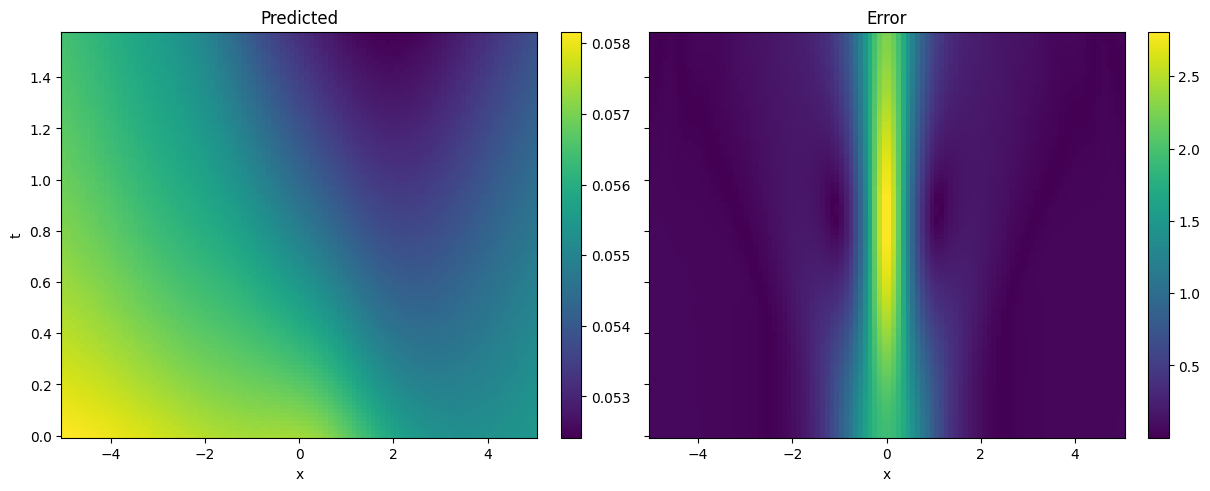

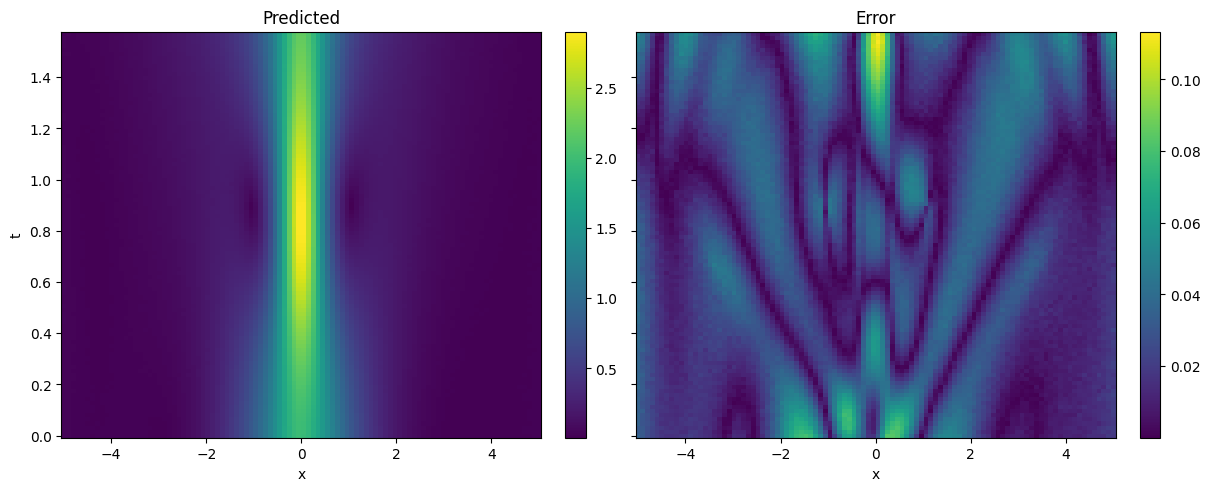

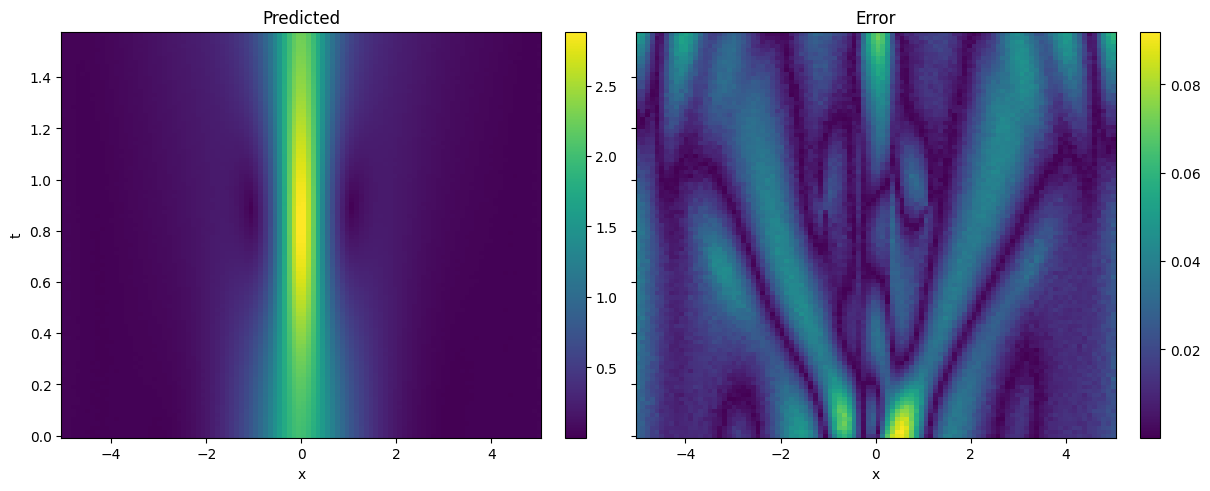

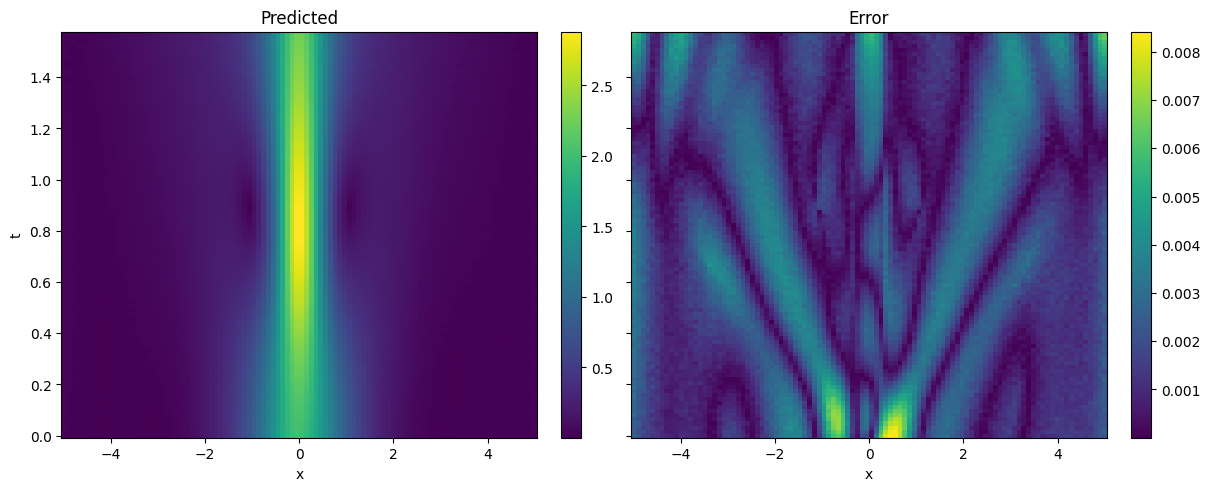

In [10]:
%%time
nse.train()
print(nse.step, nse.ls.item())

In [13]:
%%time
nse.train()
print(nse.step, nse.ls.item())

Step: 100000, Loss: 0.0013423437485471368
Step: 100100, Loss: 0.0013760249130427837
Step: 100200, Loss: 0.0013978962088003755
Step: 100300, Loss: 0.0016177978832274675
Step: 100400, Loss: 0.0015611848793923855
Step: 100500, Loss: 0.001331001054495573
Step: 100600, Loss: 0.001346587436273694
Step: 100700, Loss: 0.0013168137520551682
Step: 100800, Loss: 0.001306422520428896
Step: 100900, Loss: 0.0013735552784055471
Step: 101000, Loss: 0.0013903764775022864
Step: 101100, Loss: 0.0013352633686736226
Step: 101200, Loss: 0.00131156574934721
Step: 101300, Loss: 0.0013305072207003832
Step: 101400, Loss: 0.0013391992542892694
Step: 101500, Loss: 0.0013646968873217702
Step: 101600, Loss: 0.0015452421503141522
Step: 101700, Loss: 0.0013232603669166565
Step: 101800, Loss: 0.0013527399860322475
Step: 101900, Loss: 0.0014274080749601126
Step: 102000, Loss: 0.001340318936854601
Step: 102100, Loss: 0.0013383303303271532
Step: 102200, Loss: 0.00174302002415061
Step: 102300, Loss: 0.0013027468230575323


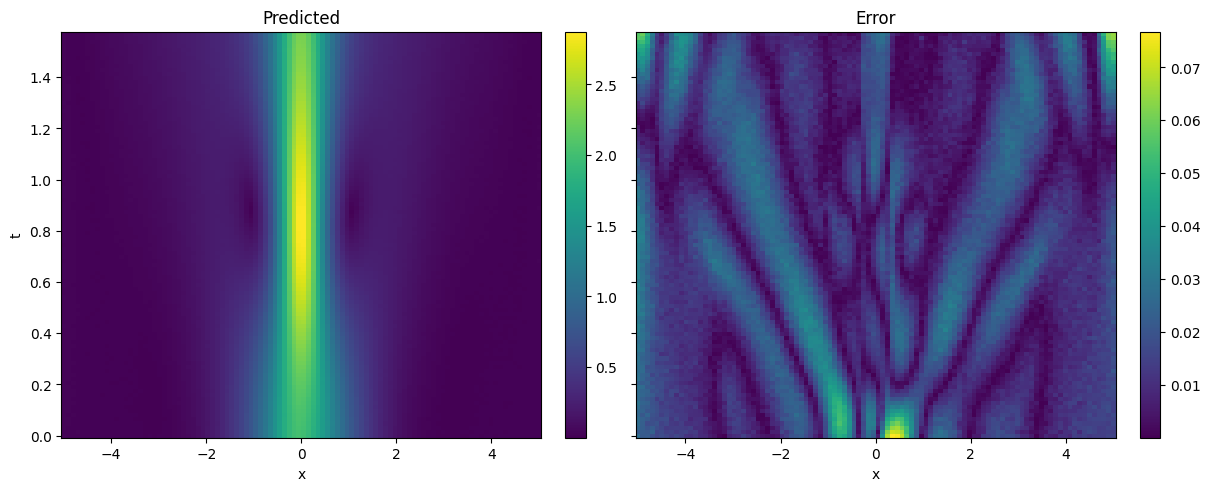

In [22]:
preds_and_errors_nse(nse)

In [119]:
x_test = torch.tensor(x_train, dtype=torch.float32, requires_grad=True, device=device) #, dtype=torch.float16,
t_test = torch.tensor(t_train, dtype=torch.float32, requires_grad=True, device=device) #, dtype=torch.float16,
torch.hstack((x_test, t_test)).shape

torch.Size([2750, 2])

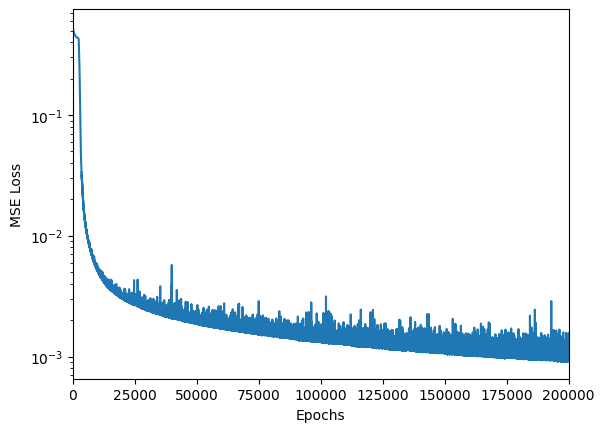

In [14]:
fig, ax = plt.subplots(1,1)
p = ax.semilogy(nse.loss)

ax.set_xlabel("Epochs")
ax.set_ylabel("MSE Loss")
#ax.axvline(10000, ls='--')
#ax.set_xticks(list(ax.get_xticks()) + [10000])
ax.set_xlim(0,200000)
plt.show()

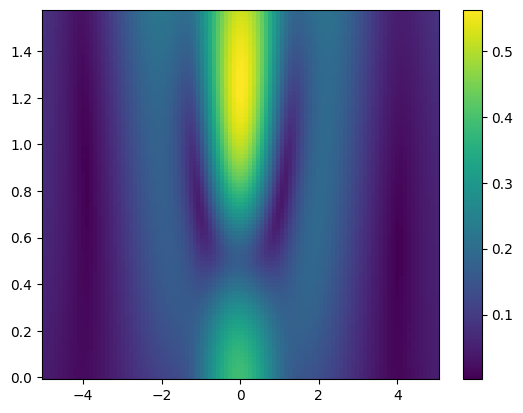

In [28]:
x_axis = torch.linspace(-5, 5, 100)
t_axis = torch.linspace(0, pi/2 ,100)

x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing='xy')
xt_pairs = torch.stack((x_grid, t_grid), dim=2)
xt_pairs = xt_pairs.reshape(xt_pairs.shape[0] * xt_pairs.shape[1],2).to(device)

preds_adam = nse.net(xt_pairs)
absval = torch.sqrt(preds_adam[:,0:1]**2 + preds_adam[:,1:2]**2).reshape((100,100)).detach().cpu()

plt.pcolormesh(x_grid.numpy(), t_grid.numpy(), absval.numpy())
plt.colorbar()
plt.show()

In [85]:
nse_l = PINN(x_train, t_train, u_train, v_train, dDim=128, nHid=8)

Step: 0, Loss: 0.5444530844688416
Step: 100, Loss: 0.44655588269233704
Step: 200, Loss: 0.29926636815071106
Step: 300, Loss: 0.2166321724653244
Step: 400, Loss: 0.1833924502134323
Step: 500, Loss: 0.12660130858421326
Step: 600, Loss: 0.0828099474310875
Step: 700, Loss: 0.10901834070682526
Step: 800, Loss: 0.04590820521116257
Step: 900, Loss: 0.03077925741672516
Switching to LBFGS at 1000!!
Step: 1000, Loss: 0.030064575374126434
1022 0.0244976207613945
CPU times: total: 17.3 s
Wall time: 17.6 s


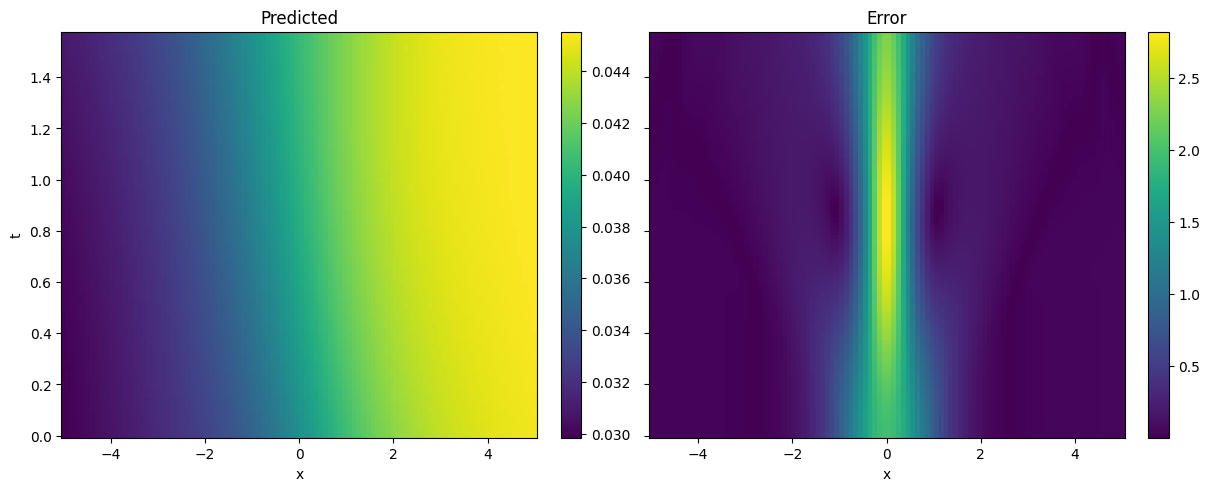

In [86]:
%%time
nse_l.train()
print(nse_l.step, nse_l.ls.item())

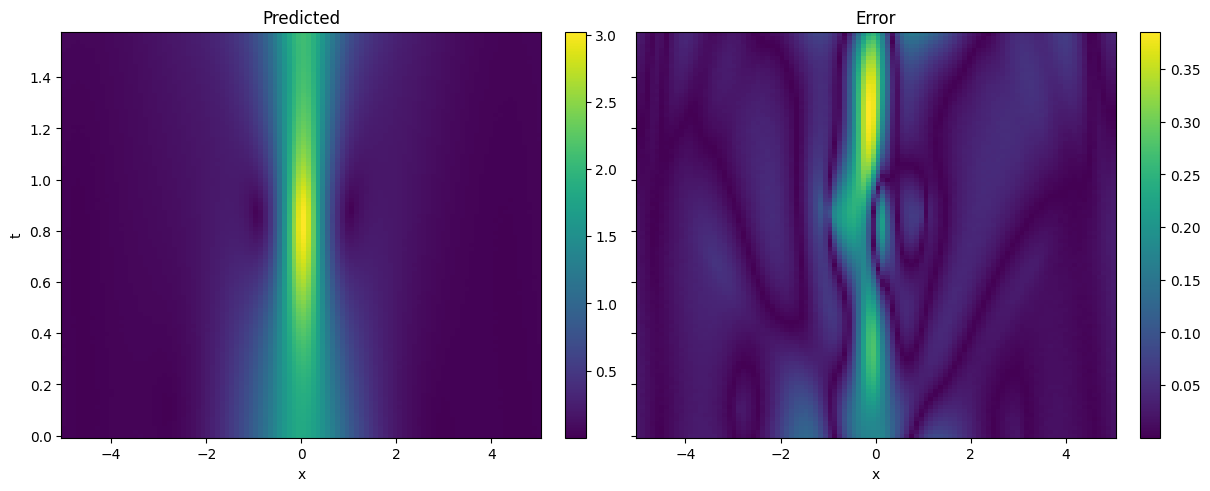

In [87]:
preds_and_errors_nse(nse_l)

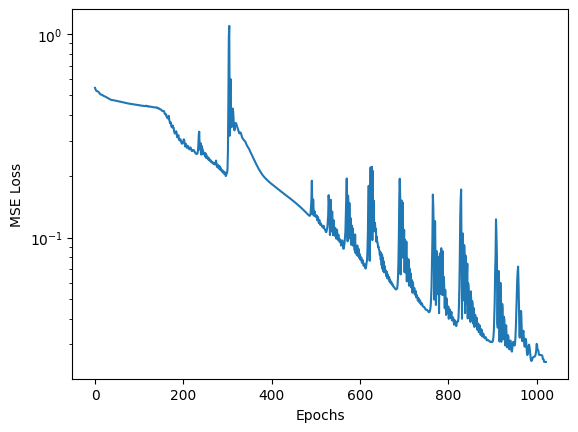

In [88]:
fig, ax = plt.subplots(1,1)
p = ax.semilogy(nse_l.loss)

ax.set_xlabel("Epochs")
ax.set_ylabel("MSE Loss")
#ax.axvline(10000, ls='--')
#ax.set_xticks(list(ax.get_xticks()) + [10000])
#ax.set_xlim(0,)
plt.show()

In [174]:
25*60+6

1506

In [38]:
df = pd.DataFrame(columns=[2,4,6,8,10])
for n_layers in [2,4,6,8,10]:
    print('%%%%%%%%%%%%%%%')
    print(str(n_layers))
    print('%%%%%%%%%%%%%%%')
    tmp = []
    for dim in [32,64,128,256]:
        print('########' + str(dim) + '##########')
        model = PINN(x_train, t_train, u_train, v_train, dDim=dim, nHid=n_layers)
        model.train()
        tmp.append(model.ls.item())
    df[n_layers] = pd.Series(tmp)

df

%%%%%%%%%%%%%%%
2
%%%%%%%%%%%%%%%
########32##########
Step: 0, Loss: 0.8071520924568176
Step: 100, Loss: 0.6031347513198853
Step: 200, Loss: 0.5878775715827942
Step: 300, Loss: 0.5699290633201599
Step: 400, Loss: 0.5657209157943726
########64##########
Step: 0, Loss: 0.6887096762657166
Step: 100, Loss: 0.5769491195678711
Step: 200, Loss: 0.5651320219039917
Step: 300, Loss: 0.5625506043434143
Step: 400, Loss: 0.5617358088493347
########128##########
Step: 0, Loss: 0.6827534437179565
Step: 100, Loss: 0.5709178447723389
Step: 200, Loss: 0.5637021064758301
Step: 300, Loss: 0.5613073110580444
Step: 400, Loss: 0.5528180003166199
########256##########
Step: 0, Loss: 0.6631656289100647
Step: 100, Loss: 0.5866662263870239
Step: 200, Loss: 0.5681953430175781
Step: 300, Loss: 0.5652268528938293
Step: 400, Loss: 0.5633827447891235
%%%%%%%%%%%%%%%
4
%%%%%%%%%%%%%%%
########32##########
Step: 0, Loss: 0.6658505201339722
Step: 100, Loss: 0.5807770490646362
Step: 200, Loss: 0.563727617263794
Step: 30

,2,4,6,8,10
0,0.563969,0.560258,0.561296,0.552531,0.561148
1,0.560691,0.561695,0.555432,0.552559,0.574693
2,0.277914,0.382593,0.559139,0.256494,0.356443
3,0.561896,0.455381,0.454021,0.579019,0.655864


In [207]:
nse_b = PINN(x_train, t_train, u_train, v_train, dDim=128, nHid=8)

Step: 0, Loss: 0.5349065819449781
Step: 100, Loss: 0.46862159402101433
Step: 200, Loss: 0.44629415594591926
Step: 300, Loss: 0.4368391819986873
Step: 400, Loss: 0.2957840241297733
Switching to LBFGS at 500!!
Step: 500, Loss: 0.21536122573270264
Step: 600, Loss: 0.09047031657733773
Step: 700, Loss: 0.08336058276669393
Step: 800, Loss: 0.013785274756879053
Step: 900, Loss: 0.01467639015783875
Step: 1000, Loss: 0.010629188144296205
Step: 1100, Loss: 0.004554081606378154
Step: 1200, Loss: 0.0028975585303472537
Step: 1300, Loss: 0.0023447897434212984
Step: 1400, Loss: 0.0020613086040875486
1500 0.0017346083242820824
CPU times: total: 3min 38s
Wall time: 3min 41s


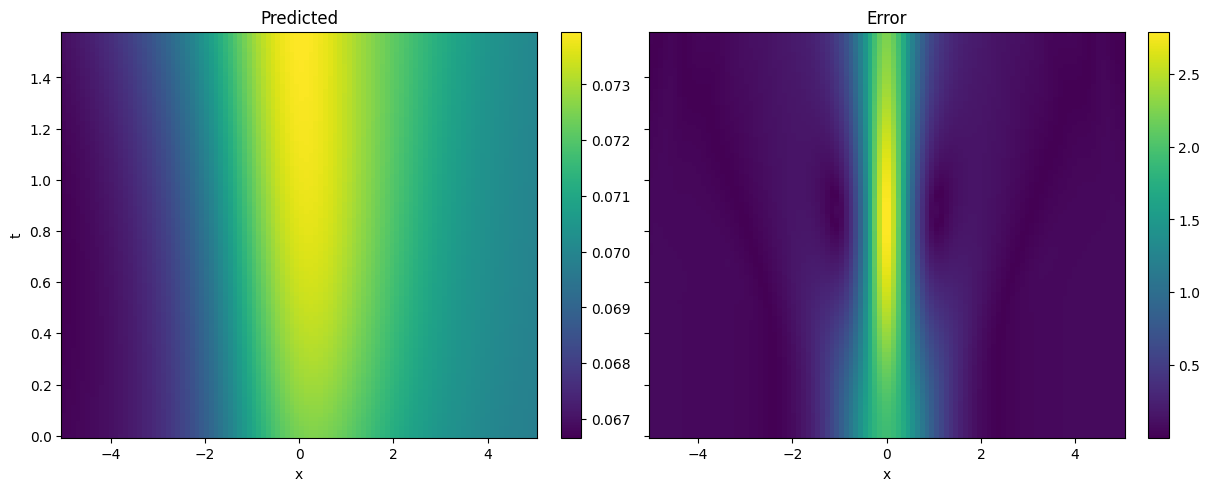

In [208]:
%%time
nse_b.train()
print(nse_b.step, nse_b.ls.item())

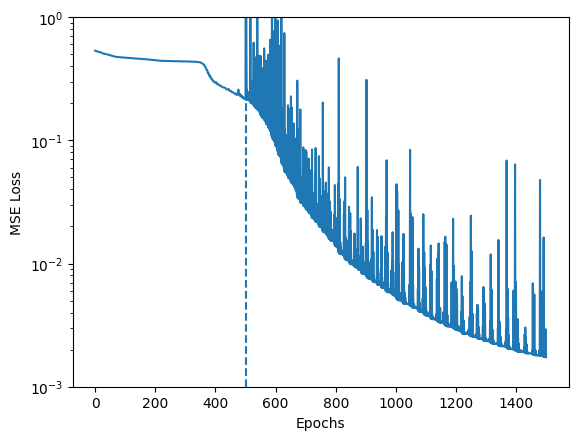

In [209]:
fig, ax = plt.subplots(1,1)
p = ax.semilogy(nse_b.loss)

ax.set_xlabel("Epochs")
ax.set_ylabel("MSE Loss")
ax.axvline(500, ls='--')
#ax.set_xticks(list(ax.get_xticks()) + [10000])
#ax.set_xlim(0,)
ax.set_ylim(0.001,1)
plt.show()

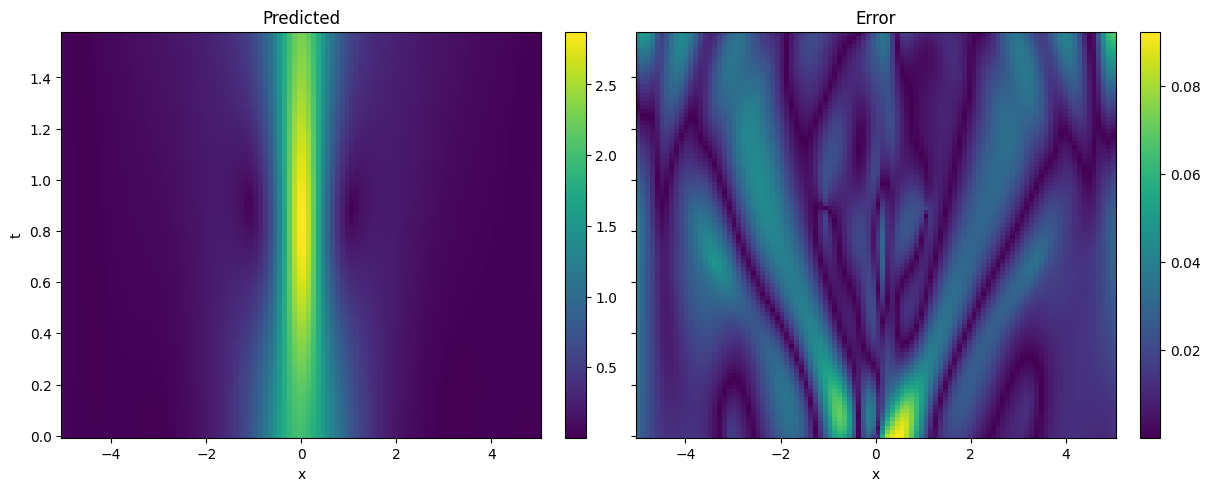

In [212]:
preds_and_errors_nse(nse_b)

In [186]:
torch.hstack((nse_b.x, nse_b.t)).dtype

torch.float64

In [195]:
nse_b.func(nse_b.x, nse_b.t)

(tensor([[0.0138],
         [0.0138],
         [0.0139],
         ...,
         [0.0254],
         [0.0255],
         [0.0256]], device='cuda:0', dtype=torch.float64,
        grad_fn=<SliceBackward0>),
 tensor([[0.0175],
         [0.0174],
         [0.0174],
         ...,
         [0.0146],
         [0.0146],
         [0.0146]], device='cuda:0', dtype=torch.float64,
        grad_fn=<SliceBackward0>),
 tensor([[-0.0003],
         [-0.0003],
         [-0.0003],
         ...,
         [-0.0012],
         [-0.0011],
         [-0.0010]], device='cuda:0', dtype=torch.float64,
        grad_fn=<AddBackward0>),
 tensor([[ 1.0535e-04],
         [ 1.0664e-04],
         [ 1.1129e-04],
         ...,
         [ 7.7508e-06],
         [-1.6270e-05],
         [-2.7648e-05]], device='cuda:0', dtype=torch.float64,
        grad_fn=<SubBackward0>))

In [211]:
180+38

218